# Rock Paper Scissors (using Convolutional Neural Network)

## Importing dependencies

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

2025-02-07 11:04:43.663039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/administrateur/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.9.21
Tensorflow version: 2.18.0
Keras version: 3.8.0


## Loading the dataset

We will download Rock-Paper-Scissors dataset from [TensorFlow Datasets](https://github.com/tensorflow/datasets) collection. To do that we loaded a `tensorflow_datasets` module.

`tensorflow_datasets` defines a collection of datasets ready-to-use with TensorFlow.

Each dataset is defined as a [tfds.core.DatasetBuilder](https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder), which encapsulates the logic to download the dataset and construct an input pipeline, as well as contains the dataset documentation (version, splits, number of examples, etc.).

In [2]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

2025-02-07 11:04:50.913159: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|                                  | 0/2 [00:10<?, ? url/s]


Dl Size...:  47%|████████████▊              | 104/219 [00:19<00:26,  4.41 MiB/s]


Dl Completed...:  50%|█████████████             | 1/2 [00:28<00:12, 12.37s/ url]


Dl Completed...:  50%|█████████████             | 1/2 [00:42<00:12, 12.37s/ url]


Generating train examples...:   0%|             | 0/2520 [00:00<?, ? examples/s]
Generating train examples...:  70%|▋| 1771/2520 [00:01<00:00, 1770.67 examples/s
                                                                                
Shuffling tmp/rock_paper_scissors/3.0.0.incompleteU1N22G/rock_paper_scissors-tra
Shuffling tmp/rock_paper_scissors/3.0.0.incompleteU1N22G/rock_paper_scissors-tra
Shuffling tmp/rock_paper_scissors/3.0.0.incompleteU1N22G/rock_paper_scissors-tra
Generating test examples...:   0%|               | 0/372 [00:00<?, ? examples/s]
                                                                                
Shuffling tmp/rock_paper_scissors/3.0.0.incompleteU1N22G/rock_paper_scissors-tes


Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmpiwocolh6tfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [4]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [5]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [6]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [7]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


## Exploring the dataset

In [8]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

2025-02-07 11:05:46.981603: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-07 11:05:47.120545: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-07 11:05:47.130631: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


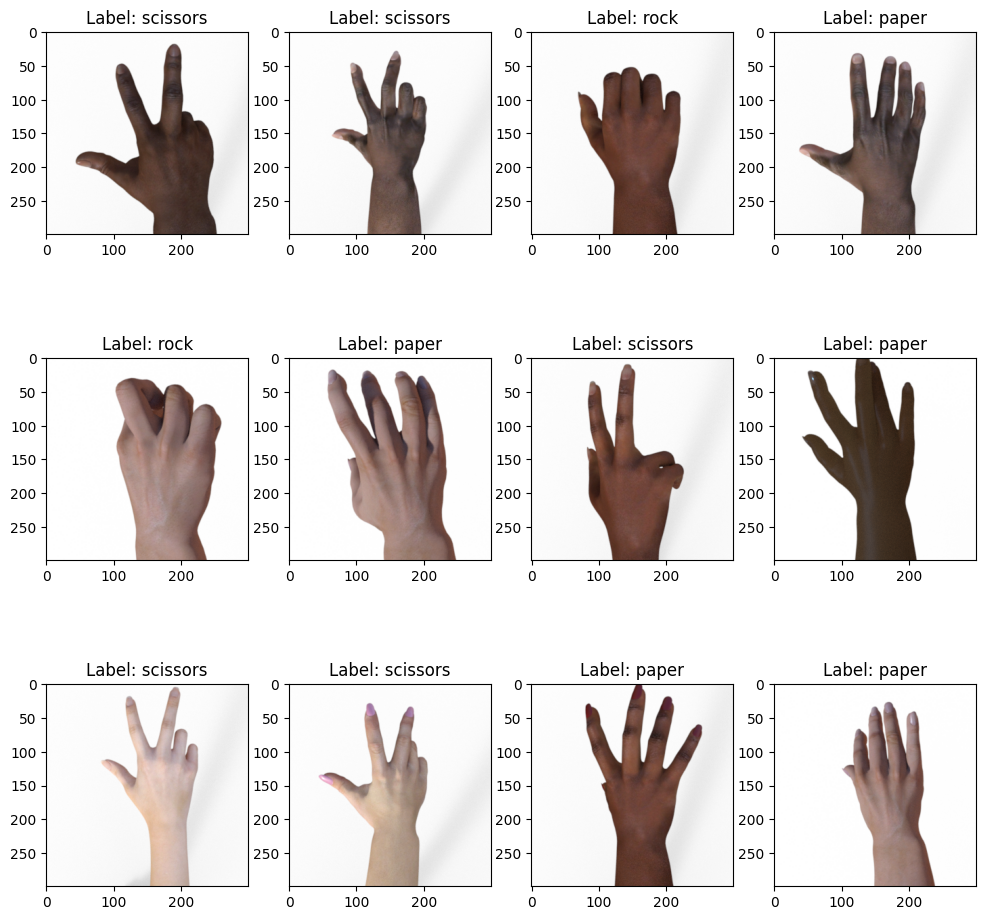

In [9]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [10]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


2025-02-07 11:05:48.475738: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-07 11:05:48.479031: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Pre-processing the dataset

In [11]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [12]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [13]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

2025-02-07 11:05:48.651861: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Data augmentation

One of the way to fight the [model overfitting](https://en.wikipedia.org/wiki/Overfitting) and to generalize the model to a broader set of examples is to augment the training data.

As you saw from the previous section all training examples have a white background and vertically positioned right hands. But what if the image with the hand will be horizontally positioned or what if the background will not be that bright. What if instead of a right hand the model will see a left hand. To make our model a little bit more universal we're going to flip and rotate images and also to adjust background colors.   

You may read more about a [Simple and efficient data augmentations using the Tensorfow tf.Data and Dataset API](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/).

In [14]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [15]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [16]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [17]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [18]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [19]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [20]:
dataset_train_augmented = dataset_train.map(augment_data)

2025-02-07 11:05:49.565261: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-02-07 11:05:49.600927: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


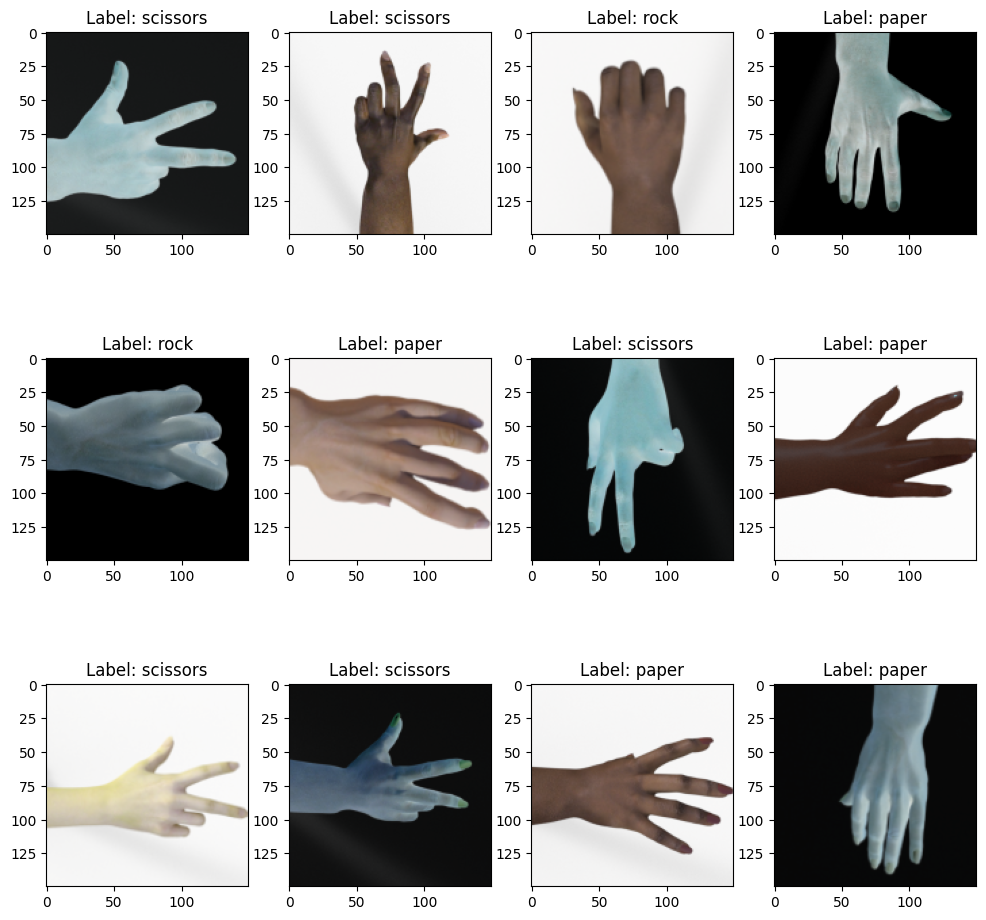

In [21]:
# Explore augmented training dataset.
preview_dataset(dataset_train_augmented)

## Data shuffling and batching

We don't want our model to learn anything from the order or grouping of the images in the dataset. To avoid that we will shuffle the training examples. Also we're going to split the training set by batches to speed up training process and make it less memory consuming.

In [22]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [23]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.06107384 0.06197953 0.06284654]
  [0.06158382 0.06248957 0.06335652]
  [0.06121147 0.06211722 0.06298417]
  ...
  [0.05325431 0.05416    0.05502695]
  [0.05296296 0.05386859 0.0547356 ]
  [0.05245936 0.05336505 0.054232  ]]

 [[0.0598647  0.06077039 0.06163734]
  [0.05970484 0.06061053 0.06147748]
  [0.05976528 0.06067097 0.06153792]
  ...
  [0.05249083 0.05339652 0.05426347]
  [0.05208445 0.05299014 0.05385709]
  [0.0523119  0.05321759 0.05408454]]

 [[0.06065691 0.0615626  0.06242961]
  [0.05929434 0.06020004 0.06106699]
  [0.05914509 0.06005079 0.06091774]
  ...
  [0.05242038 0.05332607 0.05419302]
  [0.05220741 0.0531131  0.05398005]
  [0.05261236 0.053518   0.05438501]]

 ...

 [[0.07561922 0.07652491 0.07739192]
  [0.07514095 0.07604665 0.0769136 ]
  [0.07572371 0.0766294  0.07749635]
  ...
  [0.05965489 0.06056

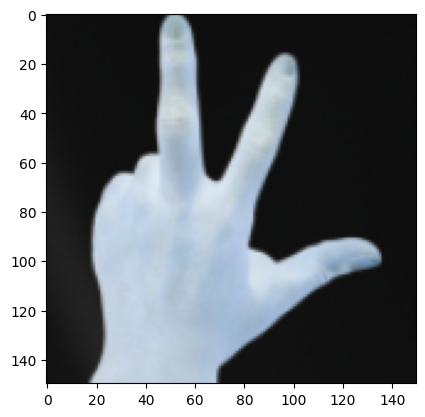

2025-02-07 11:06:38.349845: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [24]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

## Creating the model

In [ ]:
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.1))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.1))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.2))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))
model.add(tf.keras.layers.Dropout(0.2))

#================= DEEP ========================================

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dropout(0.2))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.Dropout(0.3))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [ ]:
#Modele prometteur
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Conv2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=256,
    kernel_size=3,
    activation=None  # Pas d'activation ici
))
model.add(BatchNormalization())  # Normalisation après la convolution
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))  # Puis l'activation
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Second convolution.
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation=None))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Third convolution.
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=None))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Fourth convolution.
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation=None))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

#================= DEEP ========================================
# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dropout(0.2))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.3))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax))

In [ ]:
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()

# First convolution
model.add(tf.keras.layers.Conv2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=64,
    kernel_size=3,
    padding="same",
    activation=None
))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Second convolution
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation=None))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

# Third convolution
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=None))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

# Fourth convolution
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation=None))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.2))

#================= DEEP ========================================

# Flatten layer
model.add(tf.keras.layers.Flatten())

# Dense layer
model.add(tf.keras.layers.Dense(units=512, activation=None))
model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
model.add(tf.keras.layers.Dropout(0.3))

# Output layer
model.add(tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax"))

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(INPUT_IMG_SHAPE)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=NUM_CLASSES, activation="softmax"))

In [29]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 75)   │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 75)   │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 38, 25)     │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9025)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,621,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,670,626 (17.82 MB)

 Trainable params: 4,670,326 (17.82 MB)

 Non-trainable params: 300 (1.17 KB)

## Compiling the model

In [31]:

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])

## Training the model

In [32]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [33]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5026 - loss: 2.7619 - val_accuracy: 0.3324 - val_loss: 4.1862
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8037 - loss: 0.4618 - val_accuracy: 0.3324 - val_loss: 4.8017
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9002 - loss: 0.2880 - val_accuracy: 0.4176 - val_loss: 6.1401
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9274 - loss: 0.2136 - val_accuracy: 0.5284 - val_loss: 4.8089
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.9558 - loss: 0.1338 - val_accuracy: 0.4716 - val_loss: 5.2727
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9495 - loss: 0.1462 - val_accuracy: 0.5994 - val_loss: 3.2070
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9746 - loss: 0.0706 - val_accuracy: 0.5341 - val_loss: 2.5045
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9692 - loss: 0.1077 - val_accuracy: 0.8409 - v

In [34]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

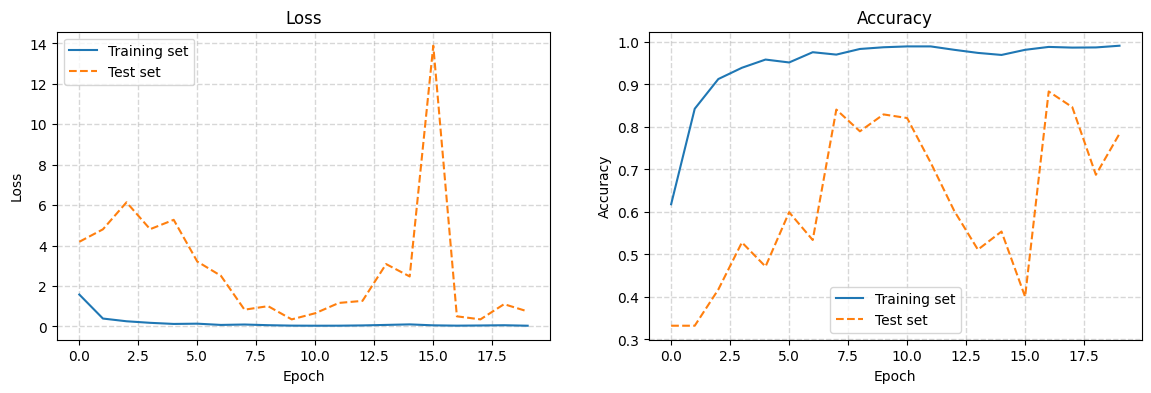

In [35]:
render_training_history(training_history)

## Evaluating model accuracy

In [36]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - accuracy: 0.9531 - loss: 0.1375
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.7946 - loss: 0.6554


## Fine tuning

In [42]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [43]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9970 - loss: 0.0103 - val_accuracy: 0.8295 - val_loss: 0.4800
Epoch 2/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9947 - loss: 0.0192 - val_accuracy: 0.8210 - val_loss: 0.5658
Epoch 3/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9931 - loss: 0.0168 - val_accuracy: 0.8153 - val_loss: 0.6455
Epoch 4/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9980 - loss: 0.0094 - val_accuracy: 0.8182 - val_loss: 0.6521
Epoch 5/5
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9970 - loss: 0.0126 - val_accuracy: 0.8153 - val_loss: 0.6330


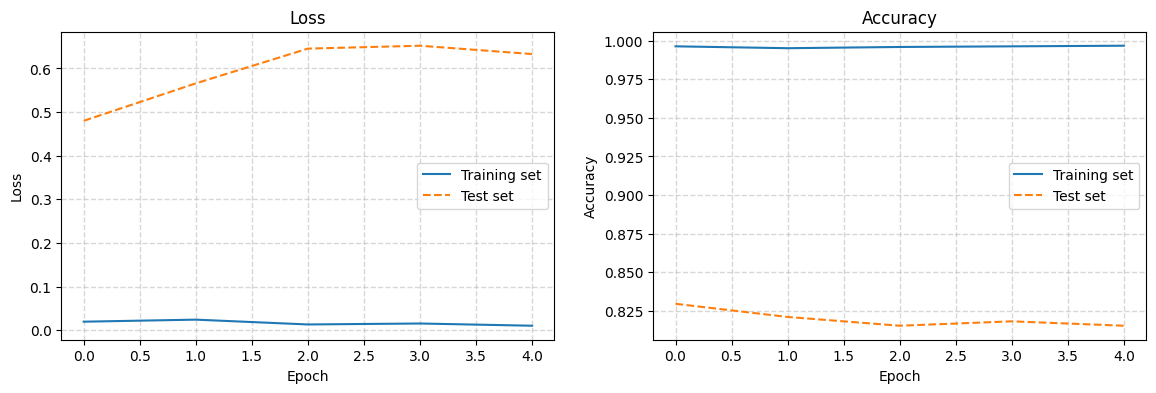

In [44]:
render_training_history(training_history)

In [45]:
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - accuracy: 1.0000 - loss: 5.9108e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.8252 - loss: 0.5685


## Predictions

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(150, 150))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,150,150,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[0., 0., 1.]], dtype=float32)

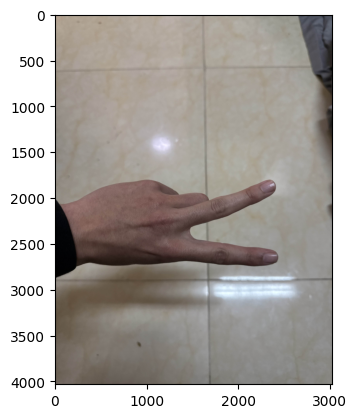

In [54]:
make_predictions('../../data/test_scissor.jpg')

## Saving the model

In [ ]:
model.save('rock_paper_scissors_cnn.h5')

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)